
# **LUCA NINIVAGGI**
 (& FLAVIO BARRARA STEFANI)
<br>
<br>

# **CARTOONIZZARE QUANTIZZANDO: EFFICIENZA & PROBLEMATICHE**


# 1. OBIETTIVI


Obiettivi descritti:
1.   Quantizzazione di canali separati
2.   Quantizzazione in spazio RGB
3.   Quantizzazione descritta da palette (+edge detection)

Altri obiettivi (Non in questo notebook):
*   Quantizzazione 1D (lineare, variabile e dinamica)
*   Edge detection & enhancing




# 2. METODI


## **IMPORT E CODICE**

In [ ]:
# @title Import

import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import data, io, color as col, feature, morphology
from matplotlib.patches import Arc
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [ ]:
# @title gestione immagini e grafici

#mostra in outuput l' immagine, se necessio grigia e con titolo
def show_img(img,subplot=111,title=None,asGray=False):
  plt.subplot(subplot)
  if asGray:
    plt.imshow(img,cmap='gray')
  else:
    plt.imshow(img)
  plt.axis('off');
  if title is not None: plt.title(title)

#leggo da file un immagine,eventualmente grigia e/o convertita a valori da 0 a 255
def img_path(path,normalize = False,gray = False):
  img = io.imread(path)
  if (gray): img = col.rgb2gray(img)
  #per evitare problemi, se è in forma float, convertiamo in un range [0,255]
  if normalize: img = img*255;  img = img.astype(int)
  return img

#grafico
def plot_histogram(values,subplot,N=256,c='red',label='Istogramma',title=None):
  values = values.copy()
  plt.subplot(subplot)
  bin_edges = np.linspace(0, 256, N + 1) - (256 / (2 * N))
  plt.hist(values.ravel(),
           orientation='vertical',
           density=True, color=c,
           alpha=0.5,
           bins=bin_edges,
           label=label)
  plt.legend(loc='upper right')
  if title is not None:plt.title(title)
  plt.xlabel('valore')
  plt.ylabel('probabilità')

#modifico l' asse Y dell' istogramma
def normalize(arr):
  total = np.sum(arr)
  if total == 0:  #se è vuoto, lo restituisco
        return arr
  return arr / total  #normalizzo

#mostro un grafico
def plot_quantization(subplot,hist,plt=plt,N=None,maxs=None,maxs_ranges=None,bin_limits=True,title=None,label='Immagine originaria',color='red',alpha=1):
  plt.subplot(subplot),
  x_values = np.arange(256)
  if N is not None:
    y_values = quantize(x_values,N=N)
  if maxs is not None:
    y_values = quantize(x_values,maxs=maxs)
    N = len(maxs)
  if maxs_ranges is not None:
    y_values = quantize(x_values,maxs_ranges=maxs_ranges)
    bin_limits=False

  plt.plot(x_values, y_values, color='blue', label='quantizzazione flat')
  plt.twiny()
  plt.plot(hist,x_values,
         color=color,
         alpha=alpha,
         label=label)

  if (bin_limits):
    dim_bin = 256/N
    for i in range(N):
      plt.axhline(i*dim_bin, linestyle='dotted',label='bin limits' if i ==0 else None)
      if maxs is None: plt.scatter(hist[int(i * dim_bin)],i * dim_bin, color='orange', label='valori scelti' if i ==0 else None)
      else:plt.scatter(hist[maxs[i]],maxs[i], color='orange',alpha=1, label='massimi' if i ==0 else None)
    plt.axhline(N*dim_bin, linestyle='dotted' )

  plt.legend(loc='upper right')
  if (title): plt.title(title)
  plt.xlabel('Input')
  plt.ylabel('Output')

def plot_multiple_quantization(subplot,hist=None,N=None,maxs=None,maxs_ranges=None,ident=False,title=None,alpha=0.5):
  plt.subplot(subplot),
  x_values = np.arange(256)

  if ident:
    plt.plot(x_values,x_values, color='black', label='Identità',alpha=alpha)
  if N is not None:
    plt.plot(x_values, quantize(x_values,N=N), color='r', label='Lineare',alpha=alpha)
  if maxs is not None:
    plt.plot(x_values, quantize(x_values,maxs=maxs), color='g', label='Variabile',alpha=alpha)
  if maxs_ranges is not None:
    plt.plot(x_values, quantize(x_values,maxs_ranges=maxs_ranges), color='b', label='Dinamica',alpha=alpha)

  plt.legend(loc='upper left')
  if (title): plt.title(title)
  plt.xlabel('Input')
  plt.ylabel('Output')
  plt.xlim(-10, 265)
  plt.ylim(-10, 265)

def plot_wrong_approssimation(points):
  fig = plt.figure(figsize=(12, 6), facecolor='white')
  axs = [
    fig.add_subplot(131, projection='3d'),
    fig.add_subplot(243),
    fig.add_subplot(247),
    fig.add_subplot(248)
  ]
  aux = fig.add_subplot(244,zorder=-1)
  aux.plot([0, 0], [0, 0])  # Just an example line to make the subplot visible

  #calcolo
  R=quantize(128,maxs_ranges=[p[0] for key, (p, c) in points.items() if key != 'P'])
  G=quantize(128,maxs_ranges=[p[1] for key, (p, c) in points.items() if key != 'P'])
  B=quantize(128,maxs_ranges=[p[2] for key, (p, c) in points.items() if key != 'P'])
  points.update({'NEW': (np.array([R, G, B]), 'grey')})


  # Plot points in the 3D projection
  for key, (p, c) in points.items():
    axs[0].scatter(*p, c=c, s=100)
    #if( key == 'NEW'): continue;
    axs[0].plot([p[0], p[0],0], [0, p[1],p[1]], [0,0,0], c=c)
    axs[0].plot([p[0],p[0]], [p[1],p[1]], [0,p[2]], c=c)
    if( key == 'NEW'): continue;
    aux.add_patch(Arc((0,0), 2 * p[1], 2 * p[1], angle=0, theta1=0, theta2=90, linestyle='--',color=c))

  axs[0].set_xlim([0, 255])
  axs[0].set_ylim([0, 255])
  axs[0].set_zlim([0, 255])

  black_dot = points['P'][0]  # The black dot coordinates
  for key, (point, color) in points.items():
    if( key == 'P'): continue;
    dist = np.linalg.norm(point - black_dot)  # Calculate Euclidean distance
    axs[0].plot([black_dot[0], point[0]], [black_dot[1], point[1]], [black_dot[2], point[2]], c=color, linestyle='--', label=f'{dist:.2f}')

  axs[0].legend(loc='upper left')

  for ax in [axs[1], axs[2], axs[3],aux]:
    ax.set_xlim([0, 255])
    ax.set_ylim([0, 255])

  for key, (p, c) in points.items():
    axs[1].scatter(p[0], p[1], c=c, s=100)
    axs[2].scatter(p[0], p[2], c=c, s=100)
    axs[3].scatter(p[1], p[2], c=c, s=100)
    if( key == 'NEW'): continue;
    axs[1].plot([p[0],p[0],0],[0,p[1],p[1]], c=c, linestyle='--')
    axs[2].plot([p[0],p[0],0],[0,p[2],p[2]], c=c, linestyle='--')
    axs[3].plot([p[1],p[1],0],[0,p[2],p[2]], c=c, linestyle='--')

  axs[1].invert_xaxis()
  axs[0].invert_yaxis()
  axs[2].invert_xaxis()
  axs[2].invert_yaxis()
  axs[3].invert_yaxis()

  axs[1].yaxis.tick_right()
  axs[2].xaxis.tick_top()
  axs[2].yaxis.tick_right()
  axs[3].xaxis.tick_top()

  axs[1].spines['top'].set_visible(False)
  axs[1].spines['left'].set_visible(False)
  axs[2].spines['bottom'].set_visible(False)
  axs[2].spines['left'].set_visible(False)
  axs[3].spines['bottom'].set_visible(False)
  axs[3].spines['right'].set_visible(False)
  aux.spines['top'].set_visible(False)
  aux.spines['right'].set_visible(False)

  axs[0].xaxis.line.set_color('red')
  axs[0].yaxis.line.set_color('green')
  axs[0].zaxis.line.set_color('blue')

  axs[1].spines['bottom'].set_color('red')
  axs[1].spines['right'].set_color('green')
  axs[2].spines['top'].set_color('red')
  axs[2].spines['right'].set_color('green')
  axs[3].spines['left'].set_color('blue')
  axs[3].spines['top'].set_color('green')

  fig.subplots_adjust(.08, .06, .99, .99, 0, 0)

  plt.show()



def plot_palette(colors, subplot):
  normalized_colors = [(R/255, G/255, B/255) for (R, G, B) in colors]
  num_colors = len(colors)
  fig = plt.gcf()
  ax = fig.add_subplot(subplot)
  ax.axis('off')
  ax.set_ylim(0, num_colors)
  for i, c in enumerate(normalized_colors):
    ax.add_patch(plt.Rectangle((0.25, num_colors-i-1), 0.5, 1, color=c))
  ax.add_patch(plt.Rectangle((0.25, 0), 0.5, num_colors, edgecolor='black',fill=False,linewidth=2))
  plt.title(f'Palette di {num_colors} colori')


In [ ]:
# @title immagini grigie

#3 versioni in cui indico insieme a val: N;max;maxs_ranges
def quantize(val,maxs=None,maxs_ranges=None, N=None):
  if isinstance(val,(np.int64,int)):
    if N is not None:
      bin_width = 256 / N
      return (val // bin_width * bin_width).astype(int)
    elif maxs is not None:
      bin_width = 256 / len(maxs)
      return maxs[int(val // bin_width)]
    elif maxs_ranges is not None:
      return find_min_diff(maxs_ranges,val)
  else:
     return np.array([quantize(val=v,maxs=maxs,maxs_ranges=maxs_ranges,N=N) for v in val])

#dato un valore e un array, ritorno il valore più vicino a val (vattori 1d)
def find_min_diff(array,val):
  min = int(256)
  best = None
  for v  in array:
    if (v == -1): continue
    dist = abs(v - val)
    if dist < min:
      min = dist
      best = v
  return int(best)

#restiruisco l' istogramma gray, data un immagine
def histogram(img):
  data = img.flatten()
  ris = [0]*256
  for v in data:
    ris[v]+=1
  return ris

#dato un istogramma e un numero di BIN, restiruisce il massimo di ogni BIN
def find_maxs(hist, N):
    maxs = [-1] * N
    dim_bin = 256 // N  # Calcola la dimensione di ciascun bin
    for i in range(N):
        start = i * dim_bin
        end = (i + 1) * dim_bin
        max_index = start + np.argmax(hist[start:end])  # Trova l'indice del massimo all'interno del bin
        if (hist[max_index]> 0): maxs[i] = max_index
    return maxs

In [ ]:
# @title Edge Detection

#calcolo l' edge detection su un immagine a grigi
def edge_detection(img,sigma=1.0,size = 0):
  blurred = cv2.GaussianBlur(src=img, ksize=(3, 3), sigmaX=0.5)#filtro passa basso
  edges = feature.canny(blurred, sigma=sigma)#filtro passa alto
  if size > 0: edges = morphology.dilation(edges, morphology.disk(size))
  return  edges

#aggiungo gli edge
def add_edge_RGB(img,edge):
  new = np.copy(img)
  for i in range(0,len(img)):
    for j in range(0,len(img[0])):
      if (len(edge) > i and len(edge[0]) > j and edge[i][j] > 0):
        new[i][j] = (0,0,0)
  return new

In [ ]:
# @title Funzioni per immagini RGB

#converto un immaggine da RGB a GRAY, utilizzando pesi definiti
def img_as_gray(img_RGB):
  R = img_RGB[:,:,0]
  G = img_RGB[:,:,1]
  B = img_RGB[:,:,2]
  return 0.2989 * R + 0.5870 * G + 0.1140 * B

#ricostruisco un immagine a partire da 0<= N <= 3 canali separati
def img_from_channels(R=0,G=0,B=0):
  #se i canali non sono indicati, sono messi a 0
  if (type(R) != int):
    channel = np.zeros((R.shape[0], R.shape[1], 3), dtype=int)
  if (type(G) != int):
    channel = np.zeros((G.shape[0], G.shape[1], 3), dtype=int)
  if (type(B) != int):
    channel = np.zeros((B.shape[0], B.shape[1], 3), dtype=int)

  channel[:, :, 0] = R
  channel[:, :, 1] = G
  channel[:, :, 2] = B
  return channel

#costruisco una matrice 3d che descrive un istogramma RGB
def hist_3d(img,normalize=False,size=256):
  matrix = np.zeros((size, size, size),dtype=int)
  #la popolo
  r,c,channel = img_RGB.shape
  for i in range(r):
    for j in range(c):
      p = img[i][j]
      r, g, b = p[0], p[1], p[2]
      #trovo il bin
      r_bin = int(r * (size / 256))
      g_bin = int(g * (size / 256))
      b_bin = int(b * (size / 256))
      matrix[r_bin][g_bin][b_bin] += 1
  if normalize: matrix /= r*c
  return matrix

#quantizzazione dei 3 canali in contemporanea
def quantize_3d(val,maxs=None,maxs_ranges=None, N=None,colors=None,lookahead_matrix=None):
  if (len(val)==3):
    R,G,B = val
    if N is not None:
      bin_width = 256 / N;
      R = (R // bin_width * bin_width).astype(int)
      G = (G // bin_width * bin_width).astype(int)
      B = (B // bin_width * bin_width).astype(int)
      return [R,G,B]
    elif maxs is not None:
      bin_width = 256 / len(maxs)
      return maxs[int(R // bin_width)][int(G // bin_width)][int(B // bin_width)]
    elif maxs_ranges is not None:
      if lookahead_matrix is not None and not np.array_equal(lookahead_matrix[R,G,B], [-1, -1, -1]):
        return lookahead_matrix[R,G,B]
      else:
        return find_best_color(maxs_ranges.reshape(-1,3), val, lookahead_matrix)
    elif colors is not None:
      if lookahead_matrix is not None and not np.array_equal(lookahead_matrix[R,G,B], [-1, -1, -1]):
        return lookahead_matrix[R,G,B]
      else:
        return find_best_color(colors, val, lookahead_matrix)
  else:
    return np.array([quantize_3d(val=v,maxs=maxs,maxs_ranges=maxs_ranges,colors=colors,N=N,lookahead_matrix=lookahead_matrix) for v in val])

#dato un array 3d e una array di vettori 3d, restiruisce il vettore + vicino (in norma 2)
def find_best_color(colors, val,lookahead_matrix=None):
  X,Y,Z = val
  min = float('inf')
  best = None
  for [R,G,B] in colors:
  #se il massimo non è valido,skippa
    if np.array_equal([R,G,B], [-1, -1, -1]): continue
    diff = np.sqrt((X-R) ** 2 + (Y-G) ** 2 + (Z-B) ** 2)
    if diff < min:
      min = diff
      best = [R,G,B]
  if (lookahead_matrix is not None): lookahead_matrix[X,Y,Z] = best
  return best

#data una matrice (=istogramma) 3d, calcola i max nei N**3 BIN
def find_maxs_3d(probabilities, N):
    maxs = np.full((N, N, N, 3), -1, dtype=int)
    dim_bin = len(probabilities) // N
    for i in range(N):
        for j in range(N):
            for k in range(N):
                kernel = probabilities[i * dim_bin:(i + 1) * dim_bin,
                                       j * dim_bin:(j + 1) * dim_bin,
                                       k * dim_bin:(k + 1) * dim_bin]
                max_index = np.unravel_index(np.argmax(kernel), kernel.shape)
                R = max_index[0] + i * dim_bin
                G = max_index[1] + j * dim_bin
                B = max_index[2] + k * dim_bin
                # Assegna l'array di 3 int [R, G, B] alla posizione (i, j, k) di maxs, se ce un valore
                if (probabilities[R,G,B] > 0): maxs[i, j, k] = (R, G, B)
    return maxs

## **OBIETTIVO 1**

### histogram
```
def histogram(img):
  data = img.flatten()
  ris = [0]*256
  for v in data:
    ris[v]+=1
  return ris
```
A partire da un array n-dimensionale (ovvero da un singolo canale di un immagine), crea un istogramma con 256 bin.


### find_maxs
```
def find_maxs(hist, N):
    maxs = [-1] * N
    dim_bin = 256 // N  # Calcola la dimensione di ciascun bin
    for i in range(N):
        start = i * dim_bin
        end = (i + 1) * dim_bin
        max_index = start + np.argmax(hist[start:end])  # Trova l'indice del massimo all'interno del bin
        if (hist[max_index]> 0): maxs[i] = max_index
    return maxs
```
Restituisce un array "rappresentanti" (ovvero i massimi relativi) dei N BIN.


### find_min_diff
```
def find_min_diff(array,val):
  min = int(256)
  best = None
  for v  in array:
    if (v == -1): continue
    dist = abs(v - val)
    if dist < min:
      min = dist
      best = v
  return int(best)
```
Restituisce il "rappresentante" più vicino a val.


### quantize
```
def quantize(val,N=None,maxs=None,maxs_ranges=None):
  if isinstance(val,(np.int64,int)):
    if N is not None:
      bin_width = 256 / N
      return (val // bin_width * bin_width).astype(int)
    elif maxs is not None:
      bin_width = 256 / len(maxs)
      return maxs[int(val // bin_width)]
    elif maxs_ranges is not None:
      return find_min_diff(maxs_ranges,val)
  else:
     return np.array([quantize(val=v,maxs=maxs,maxs_ranges=maxs_ranges,N=N) for v in val])
```
È una funzione versatile, che dato un val, restituisce il nuovo valore, coerentemente coi parametri opzionali passati.<br>
Se val non è un intero ma un vettore n-dimensionale, tramite la ricorsione andiamo a trasformare i singoli scalari.

Il nuovo valore può essere calcolato in diversi modi, a seconda dei parametri passati:
*   N -> Quantizzazione "Lineare"<br>
Usa come rappresentanti il valore con indice minore nel bin, ovvero approssima per difetto.

*   maxs -> Quantizzazione "Variabile"<br>
Passiamo come parametro "maxs" un array che racchiude i rappresentanti di ogni bin; ogni val è approssimato al rappresentante del bin che lo contiene.

*   maxs_ranges -> Quantizzazione "Dinamica"<br>
L' array passato come parametro "maxs_ranges" rappresenta il codominio della trasformazione: val viene approssimato al valore più vicino.
<br>


## **OBIETTIVO 2-3**

###hist_3D

```
def hist_3d(img,normalize=False,size=256):
  matrix = np.zeros((size, size, size),dtype=int)
  #la popolo
  r,c,_ = img_RGB.shape
  for i in range(r):
    for j in range(c):
      p = img[i][j]
      r, g, b = p[0], p[1], p[2]
      #trovo il bin
      r_bin = int(r * (size / 256))
      g_bin = int(g * (size / 256))
      b_bin = int(b * (size / 256))
      matrix[r_bin][g_bin][b_bin] += 1
  if normalize: matrix /= r*c
  return matrix
```
Produco un array 3d (cioè una matrice) con 256 BIN per lato, che descrive la distribuzione di probabilità dei colori di un immagine in input.<br>
Di default uso 256**3 bin e non la normalizzo.


###find_maxs_3d
```
def find_maxs_3d(probabilities, N):
  maxs = np.full((N, N, N, 3), -1, dtype=int)
  dim_bin = len(probabilities) // N
  for i in range(N):
    for j in range(N):
      for k in range(N):
        #bin in cui cerco il massimo
        kernel = probabilities[i * dim_bin:(i + 1) * dim_bin,
                               j * dim_bin:(j + 1) * dim_bin,
                               k * dim_bin:(k + 1) * dim_bin]
        max_index = np.unravel_index(np.argmax(kernel), kernel.shape)
        R = max_index[0] + i * dim_bin
        G = max_index[1] + j * dim_bin
        B = max_index[2] + k * dim_bin
        # Assegna l'array di 3 int [R, G, B] alla posizione (i, j, k) di maxs, se ce un valore
        if (probabilities[R,G,B] > 0): maxs[i, j, k] = (R, G, B)
    return maxs
```
Dato in input un istogramma 3d, restituisce una matrice N**3 in cui ogni valore rappresenta il colore più presente nel relativo bin.<br>
Se un bin è vuoto, il valore è indicato con (-1,-1,-1).


###find_best_color
```
def find_best_color(colors, val,lookahead_matrix=None):
  X,Y,Z = val
  min = float('inf')
  best = None
  for [R,G,B] in colors:
  #se il massimo non è valido,skippa
    if np.array_equal([R,G,B], [-1, -1, -1]): continue
    diff = np.sqrt((X-R) ** 2 + (Y-G) ** 2 + (Z-B) ** 2)
    if diff < min:
      min = diff
      best = [R,G,B]
  if (lookahead_matrix is not None): lookahead_matrix[X,Y,Z] = best
  return best
```
Dato un valore e un array di possibili colori, restituisce il colore più vicino a val.


###quantize_3D
```
#quantizzazione dei 3 canali in contemporanea
def quantize_3d(val,maxs=None,maxs_ranges=None, N=None,colors=None,lookahead_matrix=None):
  if (len(val)==3):
    R,G,B = val
    if N is not None:
      bin_width = 256 / N;
      R = (R // bin_width * bin_width).astype(int)
      G = (G // bin_width * bin_width).astype(int)
      B = (B // bin_width * bin_width).astype(int)
      return [R,G,B]
    elif maxs is not None:
      bin_width = 256 / len(maxs)
      return maxs[int(R // bin_width)][int(G // bin_width)][int(B // bin_width)]
    elif maxs_ranges is not None:
      if lookahead_matrix is not None and not np.array_equal(lookahead_matrix[R,G,B], [-1, -1, -1]):
        return lookahead_matrix[R,G,B]
      else:
        return find_best_color(maxs_ranges.reshape(-1,3), val, lookahead_matrix)
    elif colors is not None:
      if lookahead_matrix is not None and not np.array_equal(lookahead_matrix[R,G,B], [-1, -1, -1]):
        return lookahead_matrix[R,G,B]
      else:
        return find_best_color(colors, val, lookahead_matrix)
  else:
    return np.array([quantize_3d(val=v,maxs=maxs,maxs_ranges=maxs_ranges,colors=colors,N=N,lookahead_matrix=lookahead_matrix) for v in val])
```
Funziona in modo analogo a prima, ma implementa la ricerca del colore più vicino con una "matrice di lookahead": prima di fare il calcolo, controlla se un pixel con valori analoghi è già stato calcolato, ottimizzando  i tempi d' esecuzione.




# 3. ESPERIMENTI

## 1 QUANTIZZAZIONI DI CANALI SEPARATI

Illustriamo il funzionamento della quantizzazione prendendo inanzitutto un' immagine RGB.

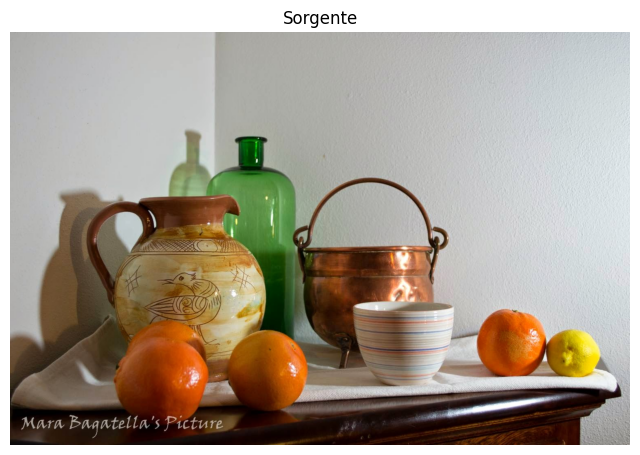

In [ ]:
plt.figure(figsize=(8,8))

img_RGB = img_path("presentazione/img_morta.jpg").astype(int)

show_img(img_RGB, 111,'Sorgente')


Visualizziamome ora i relativi istogrammi R,G,B.<br>
Utilizzando img_as_gray(img) la convertiamo in immagine a intensità luminosa, usando valori pesati<br>
Y = 0.2989 * R + 0.5870 * G + 0.1140 * B

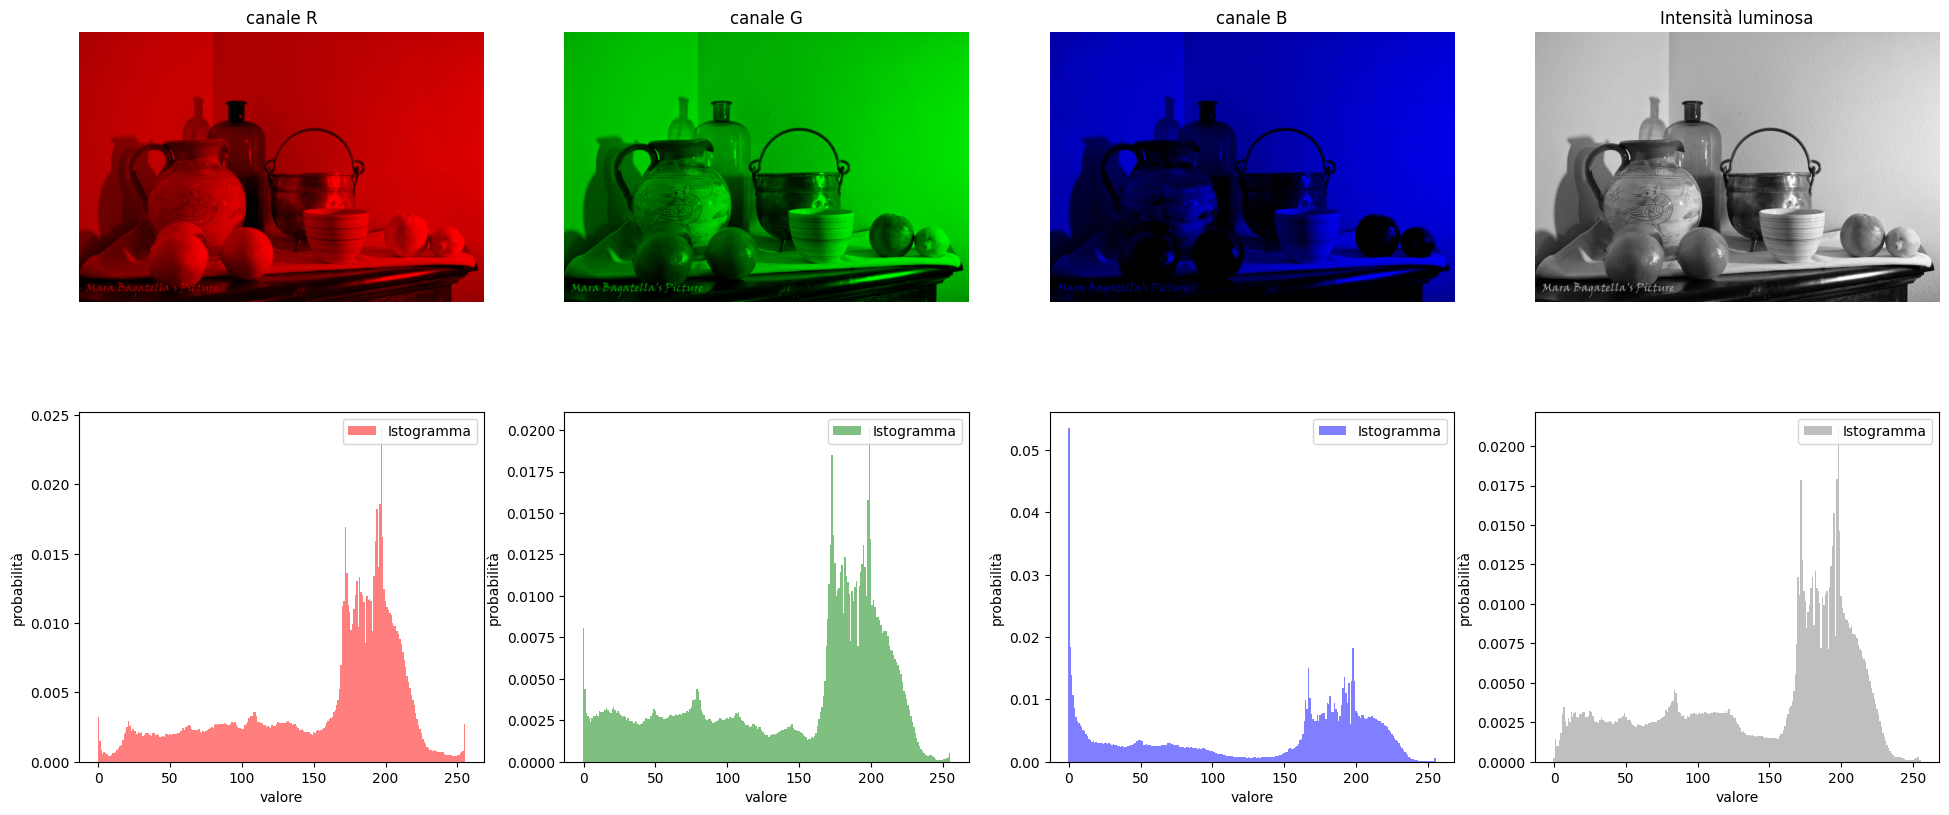

In [ ]:
#calcolo i 3 canali separati, e poi li unisco per ottenere il grigio (pesato)
R = img_RGB[:,:,0]
G = img_RGB[:,:,1]
B = img_RGB[:,:,2]
img_gray = img_as_gray(img_from_channels(R=R,G=G,B=B))


plt.figure(figsize=(24,10))
#mostro i canali separatamente
show_img(img_from_channels(R=R), 241,'canale R')
show_img(img_from_channels(G=G), 242,'canale G')
show_img(img_from_channels(B=B), 243,'canale B')
show_img(img_gray, 244,'Intensità luminosa',asGray=True)

#mostro gli istogrammi relativi ai canali
plot_histogram(R,245,c='red')
plot_histogram(G,246,c='green')
plot_histogram(B,247,c='blue')
plot_histogram(img_gray,248,c='gray')

Vediamo ora come si comportano i diversi tipi di quantizzazione separate: Statica, Variabile e Dinamica.

Supponiamo 4 BIN su ogni asse, per un totale di 64 BIN.

Per semplicità, mostriamo solo i ragionamenti effettuati lungo l' asse R.

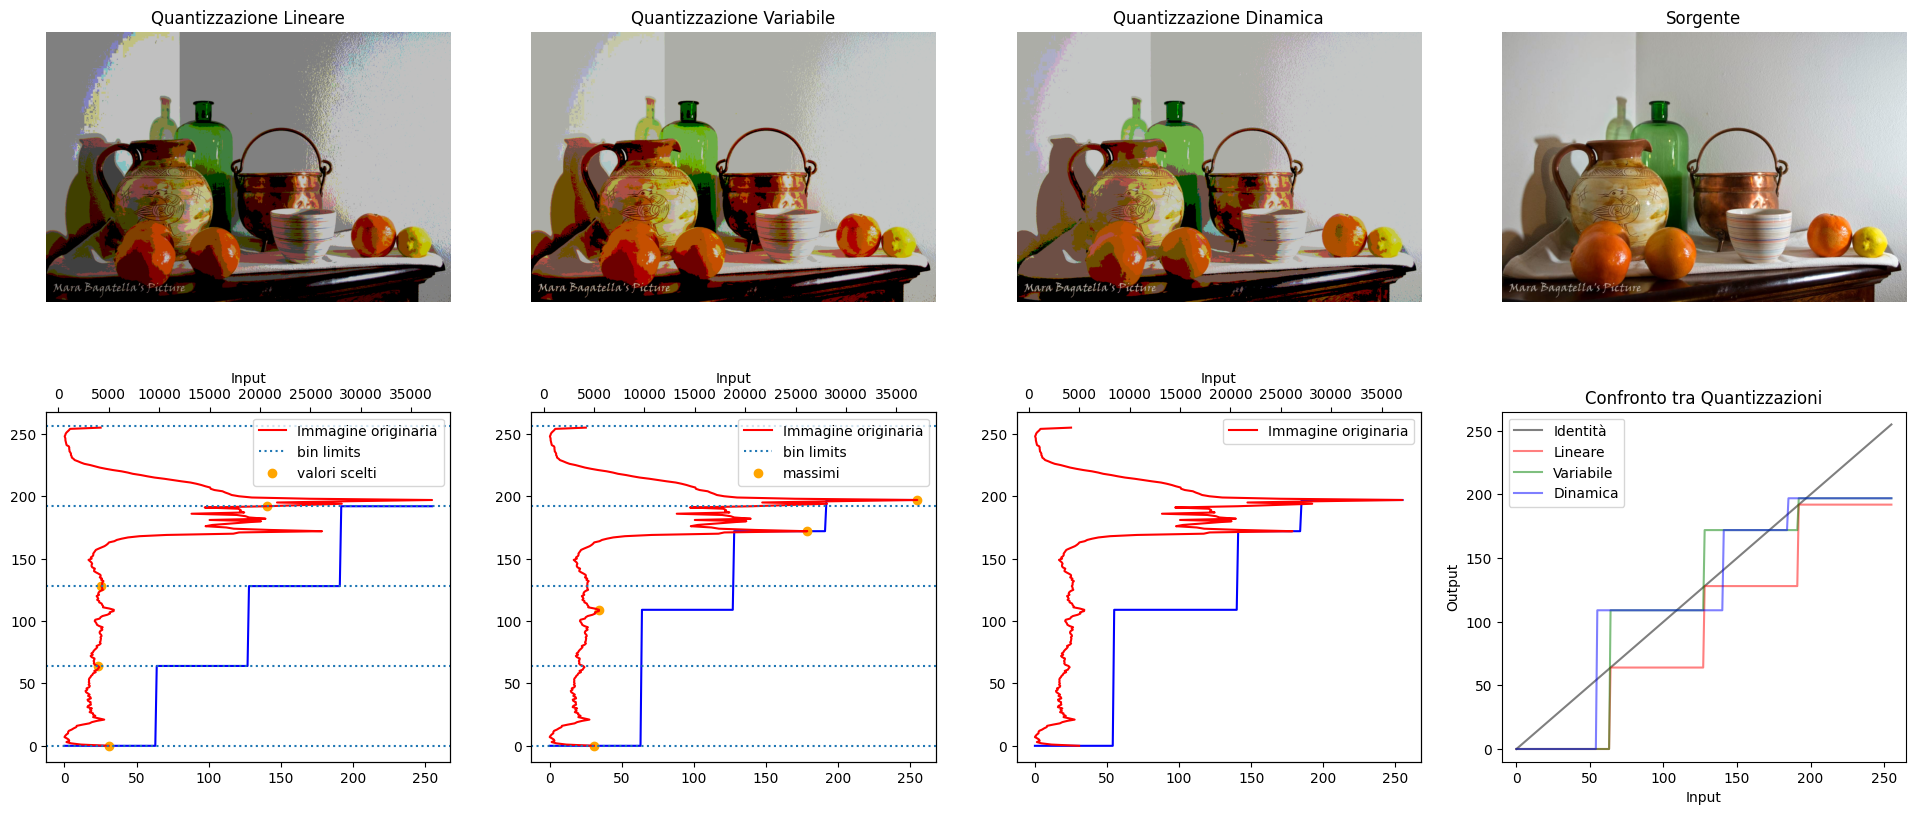

In [ ]:
N = 4

#calcolo gli istogrammi
hist_R = histogram(R)
hist_G = histogram(G)
hist_B = histogram(B)

#calcolo i massimi in ogni bin
maxs_R = find_maxs(hist_R,N)
maxs_G = find_maxs(hist_G,N)
maxs_B = find_maxs(hist_B,N)

#Quantizzazione Lineare
flat_quantize = img_from_channels(
        R=quantize(R,N=N),
        G=quantize(G,N=N),
        B=quantize(B,N=N)
        )

#Quantizzazione Variabile
variable_quantize = img_from_channels(
        R=quantize(R,maxs=maxs_R),
        G=quantize(G,maxs=maxs_G),
        B=quantize(B,maxs=maxs_B),
        )

#Quantizzazione Dinamica
dynamic_quantize = img_from_channels(
        R=quantize(R,maxs_ranges=maxs_R),
        G=quantize(G,maxs_ranges=maxs_G),
        B=quantize(B,maxs_ranges=maxs_B),
        )

#mostro l' output
plt.figure(figsize=(24,10))
plt.tight_layout()

show_img(flat_quantize, 241,'Quantizzazione Lineare')
plot_quantization(245,hist_R,N=N,color='red')

show_img(variable_quantize, 242,'Quantizzazione Variabile')
plot_quantization(246,hist_R,maxs=maxs_R,color='red')

show_img(dynamic_quantize, 243,'Quantizzazione Dinamica')
plot_quantization(247,hist_R,maxs_ranges=maxs_R,color='red')

show_img(img_RGB, 244,'Sorgente')
plot_multiple_quantization(248,N=N,maxs=maxs_R,maxs_ranges=maxs_R,title='Confronto tra Quantizzazioni',ident =True)

Possiamo notare un progressivo miglioramento nell' immagine ottenuta, anche se in tutti e 3 i casi i colori utilizzati sono **"artefatti"**.
* Nel caso della quantizzazione lineare è ovvio, in quanto andiamo a utilizzare una gamma di colori predefiniti, che non prendono in considerazione l' immagine sorgente.

* Per la quantizzazione variabile e dinamica invece, i colori dorebbero essere ricavati dallo studio degli istogrammi, ma questo accade in modo **errato**.

Proviamo a capire perchè, con un esempio.



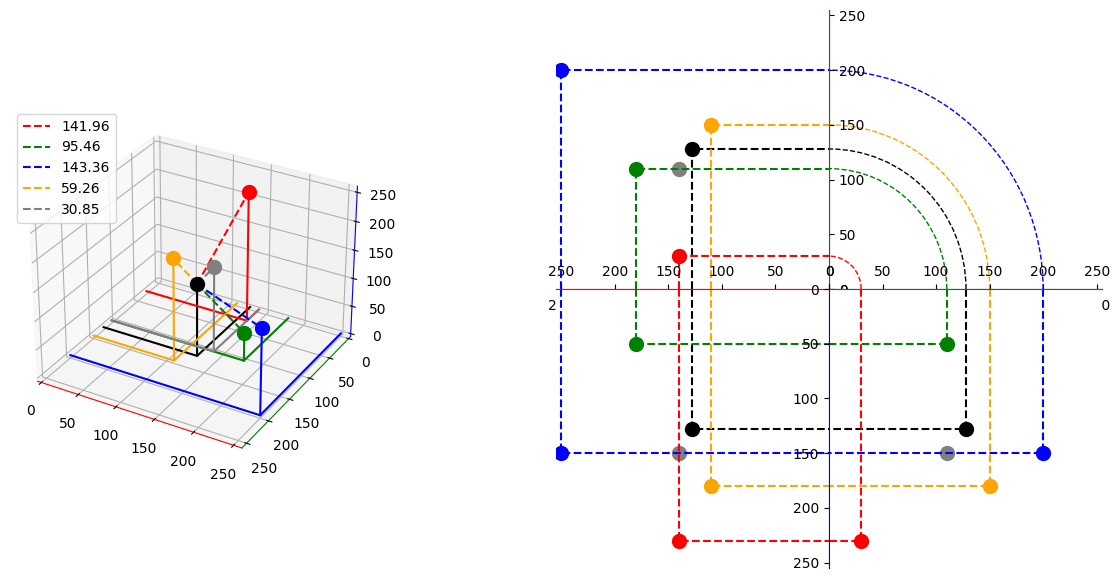

In [ ]:
points = {
    'P': (np.array([128, 128, 128]), 'black'),      #punto studiato
    'PR': (np.array([140, 30, 230]), 'red'),        #punto migliore su R
    'PG': (np.array([180, 110, 50]), 'green'),      #punto migliore su G
    'PB': (np.array([250, 200, 150]), 'blue'),      #punto migliore su B
    'PBEST': (np.array([110, 150, 180]), 'orange')  #punto migliore (teorico)
}

plot_wrong_approssimation(points)

Supponiamo di avere una "**palette** di colori", ovvero un insieme di colori che rappresentano il codominio della trasformazione (cioè i colori che ci saranno nell' immagine in output).

Prendiamo ora un pixel (<font color="black">BLACK</font>) che vogliamo sia approssimato al suo colore più vicino, in distanza euclidiana.

I colori che compongono la palette sono indicati come punti di colore <font color="red">RED</font>, <font color="green">GREEN</font>, <font color="blue">BLUE</font> e <font color="orange">ORANGE</font>.


Osservando il grafico tridimensionale, notiamo come il colore "atteso" sia quello <font color="orange">ORANGE</font>, in quanto più vicino.

Supponiamo ora di calcolare separatamente le 3 coordinate del colore atteso, dividendo in valore di R, G e B.

Guardando la Proiezione Ortogonale sulla destra, nostiamo come lungo l' asse R il valore "migliore" sia quello del punto <font color="red">RED</font>, per l' asse G quello di <font color="green">GREEN</font> e per l' asse B quello di <font color="blue">BLUE</font>.

Come approssimazione otteniamo quindi l' "artefatto" <font color="gray">GRAY</font>, di coordinate

<font color="gray">GRAY</font> = [ <font color="red">RED[R]</font>, <font color="green">GREEN[G]</font>, <font color="blue">BLUE[B]</font> ]

Possiamo allora a questo punto capire come mai, nella quantizzazione a canali separati, ad esempio il muro avesse quei colori "strani".

## 2) Quantizzazione in spazio RGB

Proviamo ora quindi a visualizzare come lo studio dello spazio RGB trasformi l' immagine.

Supponiamo come prima N=4, per un totale di 64 colori possibili.

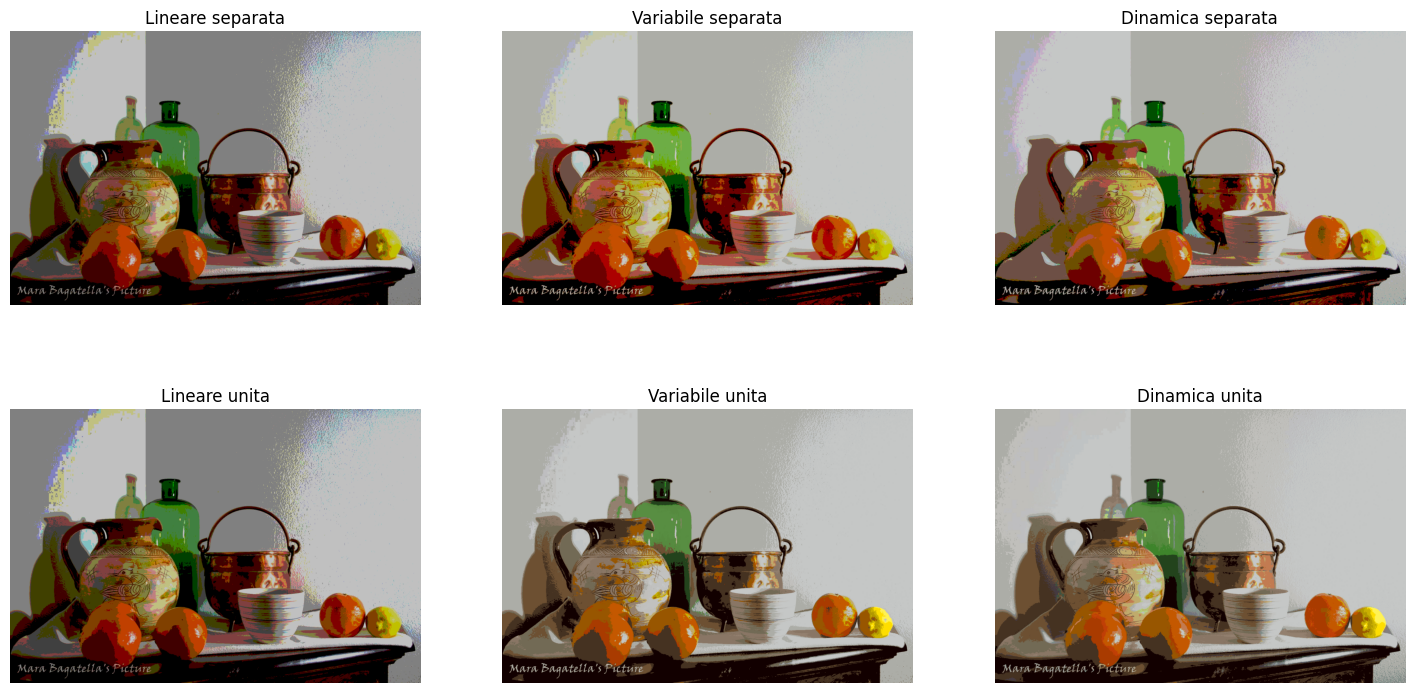

In [ ]:
N=4

flat_quantize_3D = quantize_3d(img_RGB,N=N)

#calcolo istogramma
matrix = hist_3d(img_RGB)
#calcolo massimi in n**3 bin
maxs_3d = find_maxs_3d(matrix,N)

variable_quantize_3D = quantize_3d(
    img_RGB,
    maxs = maxs_3d,
    lookahead_matrix = np.full((256, 256, 256, 3), -1, dtype=int) #migliora prestazioni
  )

dynamic_quantize_3D = quantize_3d(
    img_RGB,
    maxs_ranges = maxs_3d,
    lookahead_matrix = np.full((256, 256, 256, 3), -1, dtype=int) #migliora prestazioni
  )

#output
plt.figure(figsize=(18, 9))
plt.tight_layout()

show_img(flat_quantize,        231,'Lineare separata')
show_img(variable_quantize,    232,'Variabile separata')
show_img(dynamic_quantize,     233,'Dinamica separata')

show_img(flat_quantize_3D,     234,'Lineare unita')
show_img(variable_quantize_3D, 235,'Variabile unita')
show_img(dynamic_quantize_3D,  236,'Dinamica unita')

Come possiamo notare, poso sorprendentemente la versione Lineare risulta uguale nelle 2 versioni. <br>
Questo perchè i calcoli sono esattamente gli stessi: in pratica in ogni bin usiamo come rappresentante il vertice coi valori minori.

Per quanti riguarda la Quantizzazione Variabile, otteniamo invece un immagine coerente con lo studio dei rappresentanti.
Quindi l' immagine non è più un **artefatto**.

Con la Quantizzazione Dinamica il risultato ottenuto è ancora migliore, ad esempio possiamo notare come la bottiglia ottenga un colore più coerente con l' originale.

## 3) Quantizzazione descritta da palette

Osservando i risultati ottenuti, viene naturale chiedersi se sia necessario a monte calcolare i massimi relativi dei bin, o se i rappresentanti si possano scegliere in modo arbitrario.

Possiamo infatti scegliere una palette di colori possibili, e approssimare poi ogni pixel alla tripletta più vicina.

Per completezza, aggiungiamo dei bordi calcolati con una semplice edge detection (omettiamo la descrizione del funzionamento).

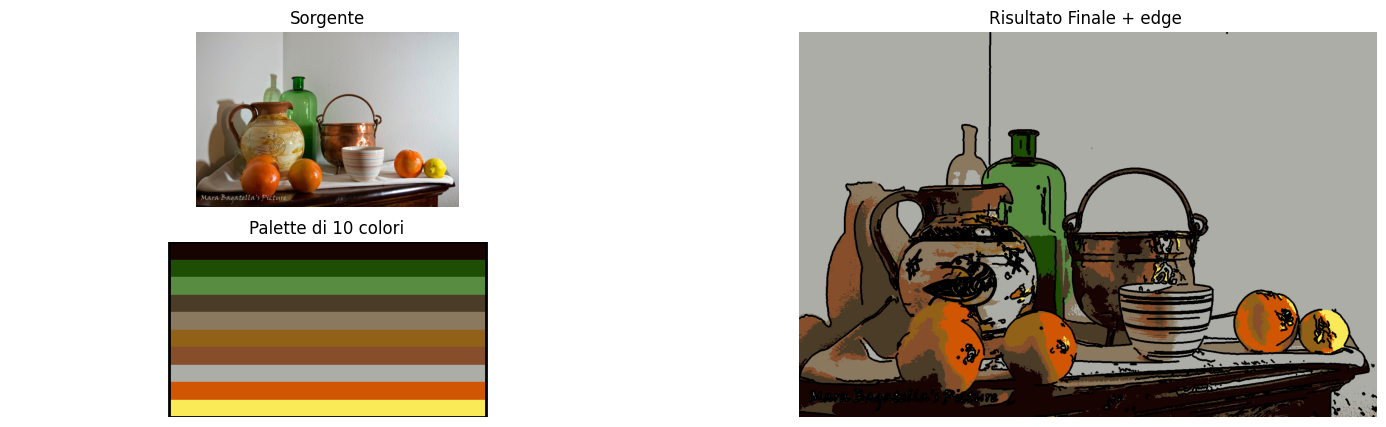

In [ ]:
colors = [
    (24, 3, 3),      # tavolo
    (30, 77, 4),     # bottiglia scura
    (88, 140, 65),   # bottiglia
    (75, 60, 40),    # ombre
    (138, 120, 95),  # ombre
    (146, 97, 24),   # vaso chiaro
    (134, 78, 43),   # vaso scuro
    (172, 173, 167), # muro
    (209, 86, 3),    # arancio
    (250, 234, 87)   # limone
]

#calcolo nuova immagine
result = quantize_3d(img_RGB,colors = colors,lookahead_matrix = np.full((256, 256, 256, 3), -1, dtype=int))

#per completezza aggiungiamo una edge detection
img_gray_not_normalized = img_path("presentazione/img_morta.jpg",gray= True)
edge = edge_detection(img_gray_not_normalized,sigma=1.4,size=2)

#mostro output
plt.figure(figsize=(18, 5))
show_img(img_RGB, 221,'Sorgente')
show_img(add_edge_RGB(result,edge), 122,'Risultato Finale + edge ')
plot_palette(colors,223)

# 4. CONCLUSIONI

##CONSIDERAZIONI FINALI

Il calcolo dell' immagine tramite Palette risulta abbastanza lento (2-3 minuti con una palette di 10 colori); questo perchè nonostante l' ottimizzazione data dalla tabella di lookhaed per ogni pixel bisogna calcolare 10 distanze in uno spazio 3D; all' aumentare della dimensione dell' immagine, il costo computazionale resta comunque gestibile.

La quantizzazione tramite palette risulta abbastanza "robusta" anche con immagini/palette di grandi dimenisoni (vedere notebook completo), anche se alcune immagini risultano problematiche, ad esempio se hanno una luminosità molto bassa o colori molto simili tra loro.<br>
Una possibile soluzione sarebbe a priori effettuare un context-stretch, oppure associare a ogni colore della palette una "forza attrattiva" variabile.

## CONFRONTO CON IL PROGETTO DI FLAVIO BARRARA STEFANI




FLavio e Io abbiamo collaborato nei progetti, dandoci come obiettivo quello di ottenere una palette di colori, e trasformare l' immagine in input usando come codominio i valori scelti.

Per quanto riguarda i suoi algoritmi, il loro obiettivo è quello di calcolarsi in modo automatico, tramite uno studio dell' immagine, una palette di N colori, e modificare l' immagine di conseguenza.

Mettiamo a confronto 3 risultati calcolati con una palette di 10 colori, rispettivamente ottenuti con:
- Il mio algoritmo (descritto precedentemente)
- K-means originale
- K-means di Flavio (semplificato)

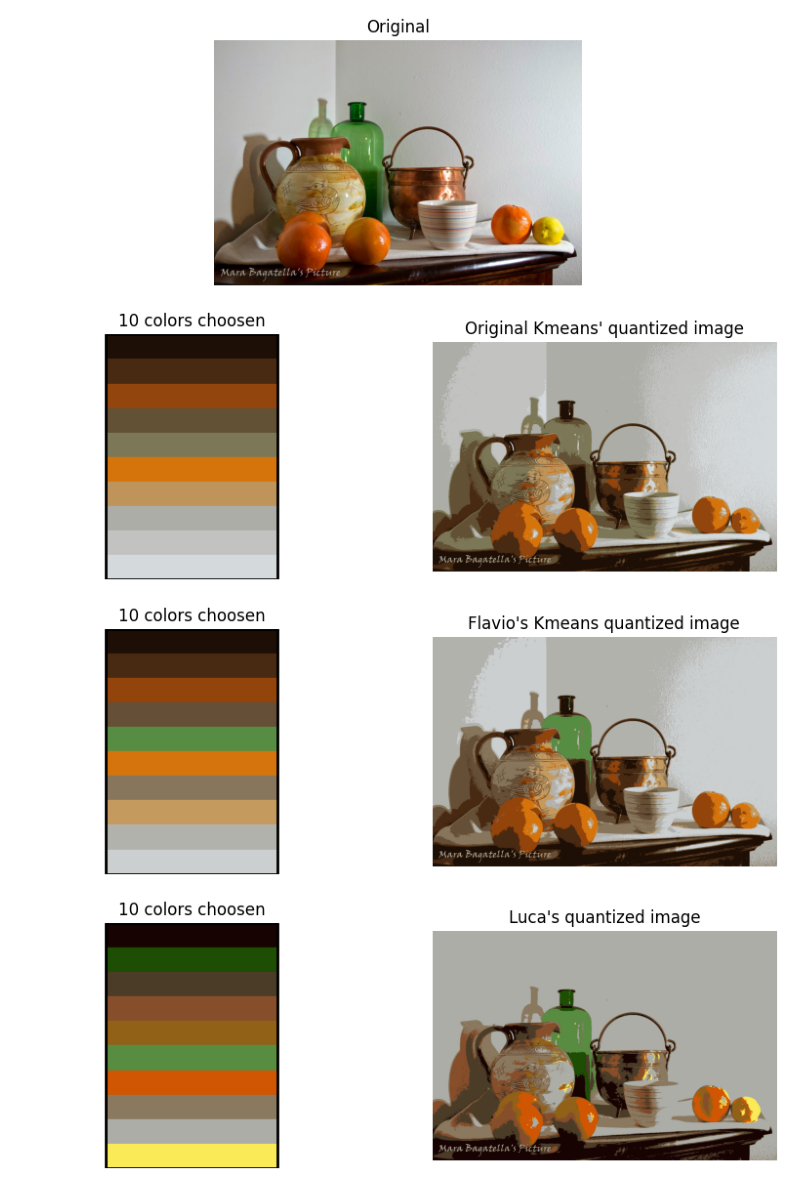

In [ ]:
plt.figure(figsize=(10,20))
show_img(img_path("presentazione/FlavioVSLuca_morta.png"))

Come si può ben vedere, alcuni dei dettagli dell'immagine vengono preservati con la quantizzazione del K-means originale, il quale ragionando matematicamente "sceglie" di ignorare ad esempio il giallo del limone ed il verde della bottiglia, la quale un occhio umano invece nota quasi come dettaglio principale.

Nella K-means implementata da flavio invece viene preservato il verde della bottiglia, seppur una sola tonalità, mentre il giallo del limone viene completamente ignorato (come nell'originale).

La scelta dei miei colori, fatta "ad occhio", risulta comunque una buona approssimazione, simile a quella ottenuta dall' algoritmo di Flavio.

Abbiamo ripetuto l'esperimento per un immagine più in alta risoluzione con sfumature di colori più distinte dalla precedente, ottenendo i seguenti risultati:

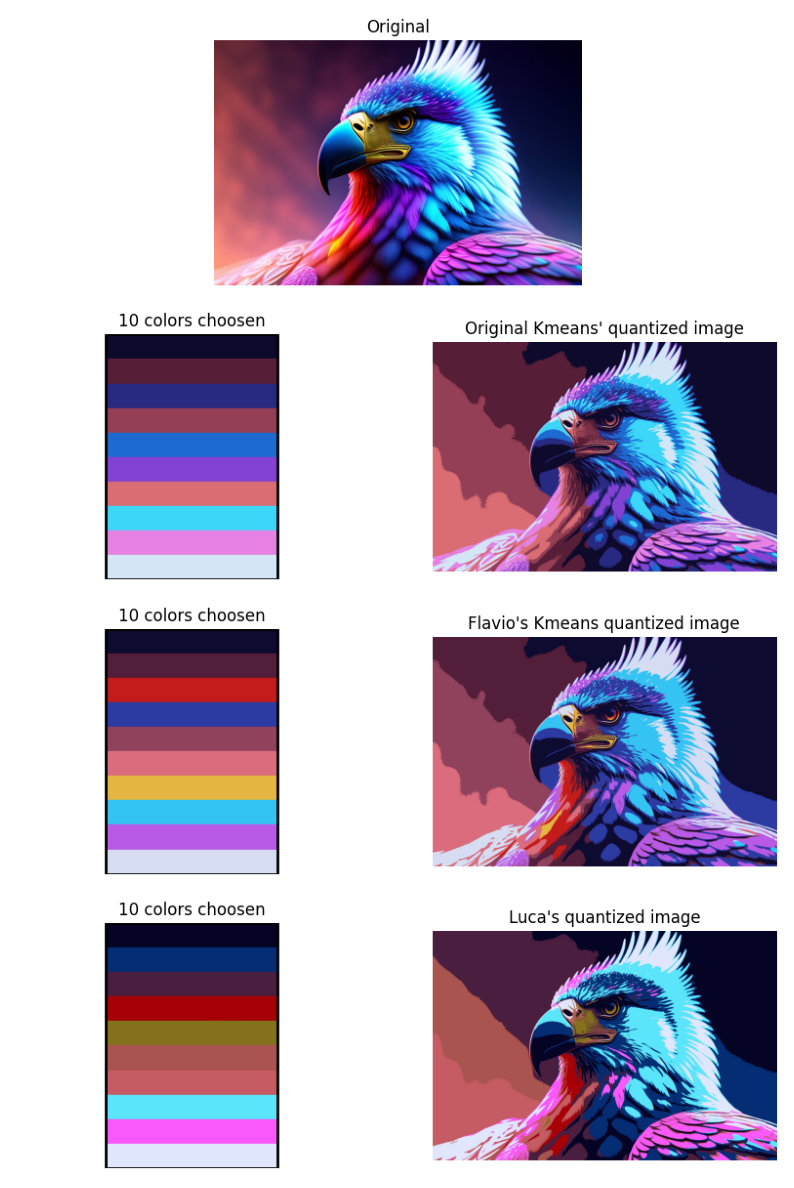

In [ ]:
plt.figure(figsize=(10,20))
show_img(img_path("presentazione/FlavioVSLuca_AI.png"))

## Modifiche post-quantizzazione (idea non implementata)


Una volta ottenuta l' immagine dalla palette, una buona idea sarebbe stata quella di poter modificare i singoli colori.

Ovvero usare la palette come un insieme di "centroidi" il cui scopo è quello di essere dei "rappresentanti" per i cluster che definiscono.

Una volta associato ogni colore a un centroide, mappando **centroide -> colore** avremmo potuto modificare solo alcune porzioni del' immagine, ad esempio solo la bottiglia verde.